In [1]:
# Cell 1: Environment Setup for Experiment 5
# Purpose: Complete router profile extraction with Node ID, Group, Speed

!pip install paramiko pandas beautifulsoup4 matplotlib -q

import paramiko
import pandas as pd
import re
import sys
from datetime import datetime
from google.colab import userdata
from bs4 import BeautifulSoup

print("="*70)
print("EXPERIMENT 5: COMPLETE ROUTER PROFILE ANALYSIS")
print("="*70)
print()
print("Objective: Extract ALL router profiles with Node ID, Group, Speed")
print("Classification: Fast / High Capacity / Standard")
print()
print("✅ Environment ready")
print(f"Python: {sys.version.split()[0]} | Pandas: {pd.__version__}")
print("="*70)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.9/223.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.3/160.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 66.9 MB/s eta 0:00:00
EXPERIMENT 5: COMPLETE ROUTER PROFILE ANALYSIS

Objective: Extract ALL router profiles with Node ID, Group, Speed
Classification: Fast / High Capacity / Standard

✅ Environment ready
Python: 3.12.12 | Pandas: 2.2.2


In [3]:
# Cell 2: SSH Connection to VPS1
# Purpose: Connect to VPS1 to access I2P profiles

from google.colab import userdata

try:
    VPS1_HOST = userdata.get('VPS1_HOST')
    VPS1_USER = userdata.get('VPS1_USERNAME')
    VPS1_PASS = userdata.get('VPS1_PASSWORD')

    print("🔐 Connecting to VPS1...")

    ssh_vps1 = paramiko.SSHClient()
    ssh_vps1.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh_vps1.connect(hostname=VPS1_HOST, username=VPS1_USER,
                     password=VPS1_PASS, timeout=15)

    print(f"✅ SSH connected: {VPS1_HOST}")

    # Verify I2P
    stdin, stdout, stderr = ssh_vps1.exec_command('pgrep -f i2p')
    if stdout.read():
        print("✅ I2P router is running")

    print()
    print("="*70)
    print("VPS1 CONNECTION: ACTIVE")
    print("="*70)

except Exception as e:
    print(f"❌ Error: {e}")

🔐 Connecting to VPS1...
✅ SSH connected: 107.175.145.4
✅ I2P router is running

VPS1 CONNECTION: ACTIVE


In [4]:
# Cell 3: Extract ALL Router Profiles (Node ID, Group, Speed)
# Purpose: Get complete dataset from I2P profiles page

def extract_all_profiles(ssh_client):
    """
    Extract complete router profile dataset:
    - Node ID (Peer ID)
    - Group (Fast / High Capacity / Standard)
    - Speed (throughput)
    """

    print("📡 Fetching profiles page...")

    cmd = "curl -L -s -m 60 http://127.0.0.1:7657/profiles?f=1 2>/dev/null"
    stdin, stdout, stderr = ssh_client.exec_command(cmd, timeout=65)
    html_content = stdout.read().decode('utf-8', errors='ignore')

    if not html_content or '<table' not in html_content:
        print("❌ No valid HTML received")
        return None

    print(f"✅ Received {len(html_content)} bytes")

    # Parse HTML
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find the profilelist table
    profile_table = soup.find('table', id='profilelist')

    if not profile_table:
        print("❌ Profile table not found")
        return None

    rows = profile_table.find_all('tr')
    print(f"📊 Found table with {len(rows)} rows")

    # Get headers
    header_cells = rows[0].find_all('th')
    headers = [cell.get_text(strip=True) for cell in header_cells]
    print(f"Headers: {headers}")

    # Find column indices
    peer_idx = next((i for i, h in enumerate(headers) if 'Peer' in h), None)
    group_idx = next((i for i, h in enumerate(headers) if 'Group' in h), None)
    speed_idx = next((i for i, h in enumerate(headers) if 'Speed' in h), None)

    if None in [peer_idx, group_idx, speed_idx]:
        print(f"❌ Missing columns")
        return None

    print(f"✓ Column indices: Peer={peer_idx}, Groups={group_idx}, Speed={speed_idx}")

    # Extract data
    profile_data = []

    print(f"\n📋 Extracting {len(rows)-1} profiles...")

    for row in rows[1:]:  # Skip header
        cells = row.find_all('td')

        if len(cells) <= max(peer_idx, group_idx, speed_idx):
            continue

        try:
            # Extract Node ID (Peer ID)
            peer_cell = cells[peer_idx]
            peer_link = peer_cell.find('a')
            if peer_link:
                node_id = peer_link.get_text(strip=True)
            else:
                continue

            # Extract Group
            group_text = cells[group_idx].get_text(strip=True)

            # Classify into tier
            if 'Fast' in group_text:
                tier = 'Fast'
            elif 'High Capacity' in group_text:
                tier = 'High Capacity'
            else:
                tier = 'Standard'

            # Extract Speed
            speed_text = cells[speed_idx].get_text(strip=True)
            try:
                speed = float(speed_text) if speed_text and speed_text != '--' else 0.0
            except:
                speed = 0.0

            profile_data.append({
                'Node_ID': node_id,
                'Group': tier,
                'Speed': speed
            })

        except Exception as e:
            continue

    # Create DataFrame
    df = pd.DataFrame(profile_data)

    print(f"\n✅ Extracted {len(df)} router profiles")

    # Summary statistics
    print("\n📊 GROUP DISTRIBUTION:")
    print("="*70)
    group_counts = df['Group'].value_counts()
    for group, count in group_counts.items():
        pct = (count / len(df)) * 100
        print(f"  {group:20s}: {count:5d} ({pct:5.1f}%)")
    print("="*70)

    # Speed statistics
    print("\n📈 SPEED STATISTICS:")
    print("="*70)
    for group in ['Fast', 'High Capacity', 'Standard']:
        group_df = df[df['Group'] == group]
        if len(group_df) > 0:
            avg_speed = group_df['Speed'].mean()
            max_speed = group_df['Speed'].max()
            print(f"  {group:20s}: Avg={avg_speed:6.2f}, Max={max_speed:6.2f}")
    print("="*70)

    return df

# Execute extraction
print("Starting complete profile extraction...\n")
profiles_complete = extract_all_profiles(ssh_vps1)

# Show sample
if profiles_complete is not None:
    print("\n📋 Sample of extracted data:")
    print(profiles_complete.head(20))

Starting complete profile extraction...

📡 Fetching profiles page...
✅ Received 6199239 bytes
📊 Found table with 9935 rows
Headers: ['Peer', 'Groups', 'Caps', 'Version', 'Speed', 'Capacity', 'Integration', 'Status', 'View/Edit']
✓ Column indices: Peer=0, Groups=1, Speed=4

📋 Extracting 9934 profiles...

✅ Extracted 9932 router profiles

📊 GROUP DISTRIBUTION:
  Standard            :  9782 ( 98.5%)
  High Capacity       :    77 (  0.8%)
  Fast                :    73 (  0.7%)

📈 SPEED STATISTICS:
  Fast                : Avg=106.14, Max=210.44
  High Capacity       : Avg= 55.11, Max= 80.48
  Standard            : Avg=  9.24, Max=232.02

📋 Sample of extracted data:
   Node_ID Group   Speed
0     DutO  Fast  122.76
1     FRWZ  Fast  105.55
2     HMP3  Fast   89.14
3     JhVt  Fast   91.39
4     Jsv5  Fast   91.06
5     KVvT  Fast   83.63
6     LRD5  Fast   86.02
7     L7TT  Fast  106.96
8     L~V9  Fast  112.32
9     Nqpx  Fast  102.28
10    OTwv  Fast  125.01
11    PHCL  Fast   99.15
12    

In [5]:
# Cell 4: Verify Data Quality - Show Samples from Each Group
# Purpose: Confirm we have Fast, High Capacity, AND Standard peers

print("="*70)
print("DATA QUALITY VERIFICATION")
print("="*70)

for group in ['Fast', 'High Capacity', 'Standard']:
    group_df = profiles_complete[profiles_complete['Group'] == group]

    print(f"\n{group.upper()} TIER - {len(group_df)} peers")
    print("-"*70)
    print(group_df.head(10).to_string(index=False))

print("\n" + "="*70)
print("✅ All three tiers confirmed present")
print("="*70)

DATA QUALITY VERIFICATION

FAST TIER - 73 peers
----------------------------------------------------------------------
Node_ID Group  Speed
   DutO  Fast 122.76
   FRWZ  Fast 105.55
   HMP3  Fast  89.14
   JhVt  Fast  91.39
   Jsv5  Fast  91.06
   KVvT  Fast  83.63
   LRD5  Fast  86.02
   L7TT  Fast 106.96
   L~V9  Fast 112.32
   Nqpx  Fast 102.28

HIGH CAPACITY TIER - 77 peers
----------------------------------------------------------------------
Node_ID         Group  Speed
   ATob High Capacity  77.66
   BX~8 High Capacity  60.58
   E-rq High Capacity  61.13
   HZHs High Capacity  65.96
   JUA~ High Capacity   0.00
   JkAw High Capacity  57.85
   Jn~M High Capacity  55.68
   KniY High Capacity   0.00
   MZ3K High Capacity  70.46
   PFXI High Capacity  49.89

STANDARD TIER - 9782 peers
----------------------------------------------------------------------
Node_ID    Group  Speed
   ABEc Standard  49.79
   ABL8 Standard   0.00
   ABRS Standard   0.00
   ABdc Standard   0.00
   ABwG St

Creating comprehensive visualization...


/tmp/ipython-input-4159358623.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(data_for_box, labels=tiers, patch_artist=True,


✅ Saved: experiment5_complete_analysis.png


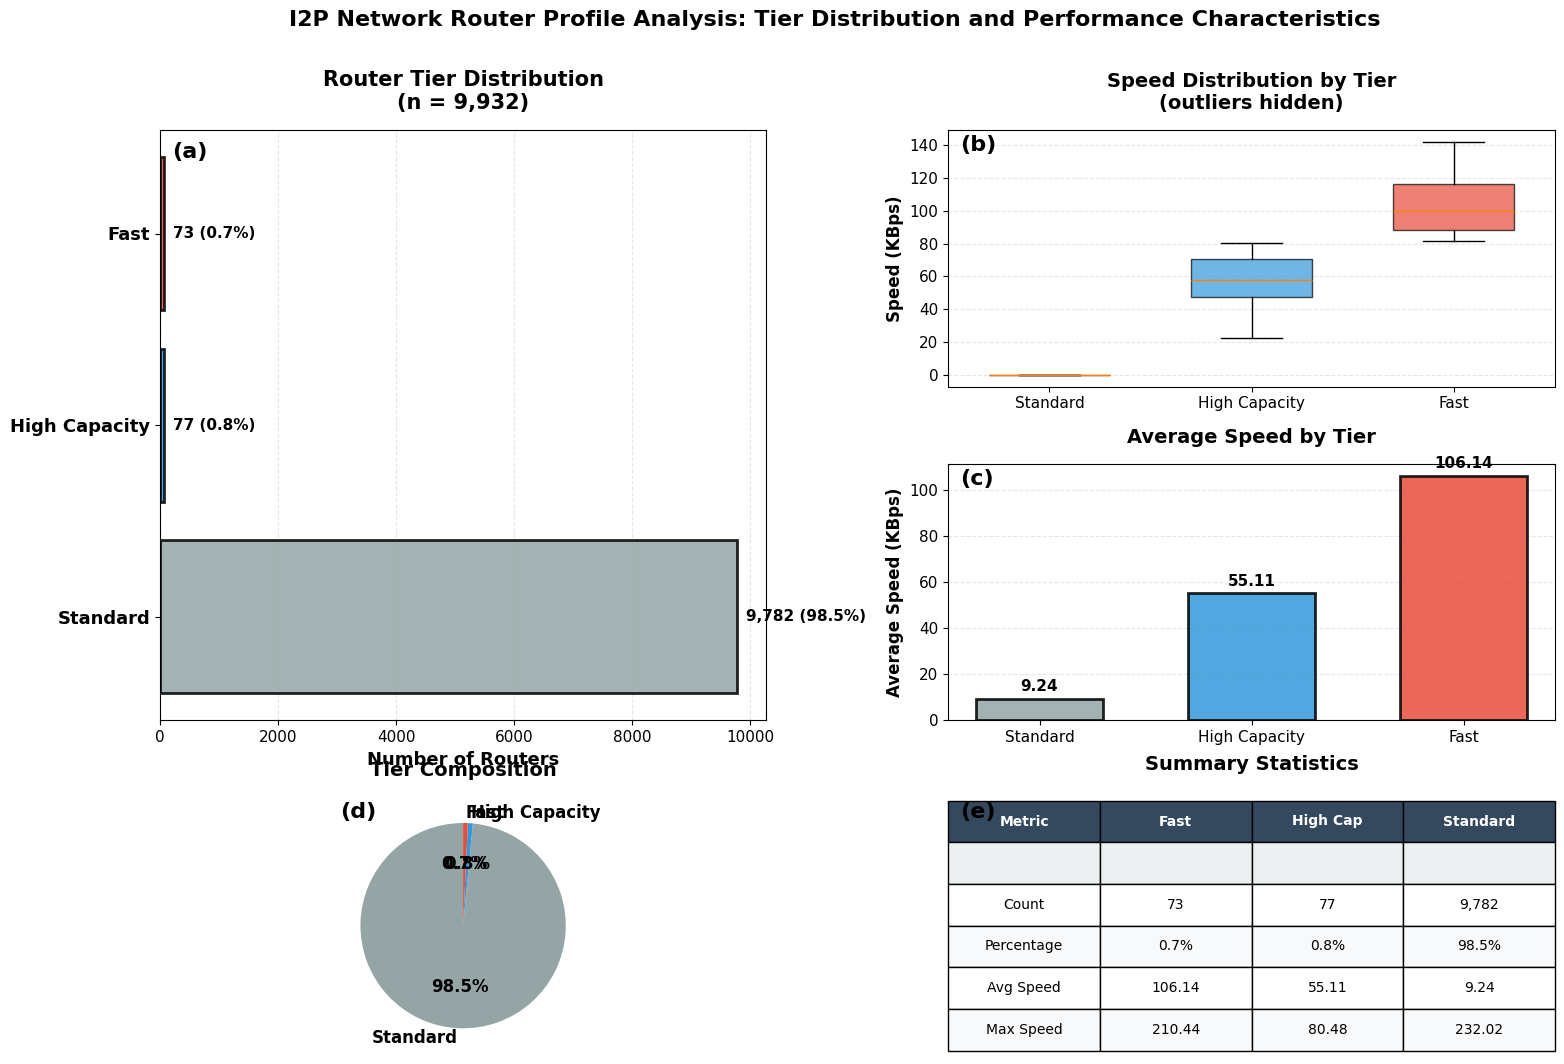

✅ Visualization complete


In [6]:
# Cell 5: Comprehensive Visualization of Router Profile Analysis
# Purpose: Publication-ready multi-panel figure

import matplotlib.pyplot as plt
import numpy as np

print("Creating comprehensive visualization...")

plt.rcParams['font.size'] = 11
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

COLORS = {'Fast': '#e74c3c', 'High Capacity': '#3498db', 'Standard': '#95a5a6'}

# ================================================================
# PANEL 1: Group Distribution (Top Left - Large)
# ================================================================
ax1 = fig.add_subplot(gs[0:2, 0])

group_counts = profiles_complete['Group'].value_counts()
tiers = ['Standard', 'High Capacity', 'Fast']
counts = [group_counts.get(t, 0) for t in tiers]
colors = [COLORS[t] for t in tiers]

bars = ax1.barh(range(3), counts, color=colors, alpha=0.85,
                edgecolor='black', linewidth=2)

ax1.set_yticks(range(3))
ax1.set_yticklabels(tiers, fontsize=13, fontweight='bold')
ax1.set_xlabel('Number of Routers', fontsize=13, fontweight='bold')
ax1.set_title('Router Tier Distribution\n(n = 9,932)',
              fontsize=15, fontweight='bold', pad=15)
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)

# Add count labels
for i, (v, tier) in enumerate(zip(counts, tiers)):
    pct = (v / sum(counts)) * 100
    ax1.text(v + 150, i, f'{v:,} ({pct:.1f}%)',
             va='center', fontsize=11, fontweight='bold')

# ================================================================
# PANEL 2: Speed Distribution by Group (Top Right)
# ================================================================
ax2 = fig.add_subplot(gs[0, 1])

# Box plot of speeds by group
data_for_box = [profiles_complete[profiles_complete['Group']==t]['Speed'].values
                for t in tiers]

bp = ax2.boxplot(data_for_box, labels=tiers, patch_artist=True,
                 showfliers=False, widths=0.6)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_ylabel('Speed (KBps)', fontsize=12, fontweight='bold')
ax2.set_title('Speed Distribution by Tier\n(outliers hidden)',
              fontsize=14, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_axisbelow(True)

# ================================================================
# PANEL 3: Average Speed Comparison (Middle Right)
# ================================================================
ax3 = fig.add_subplot(gs[1, 1])

avg_speeds = [profiles_complete[profiles_complete['Group']==t]['Speed'].mean()
              for t in tiers]

bars = ax3.bar(range(3), avg_speeds, color=colors, alpha=0.85,
               edgecolor='black', linewidth=2, width=0.6)

ax3.set_xticks(range(3))
ax3.set_xticklabels(tiers, fontsize=11)
ax3.set_ylabel('Average Speed (KBps)', fontsize=12, fontweight='bold')
ax3.set_title('Average Speed by Tier', fontsize=14, fontweight='bold', pad=15)
ax3.grid(axis='y', alpha=0.3, linestyle='--')
ax3.set_axisbelow(True)

# Add value labels
for i, v in enumerate(avg_speeds):
    ax3.text(i, v + 2, f'{v:.2f}', ha='center', va='bottom',
             fontsize=11, fontweight='bold')

# ================================================================
# PANEL 4: Tier Percentages (Bottom Left)
# ================================================================
ax4 = fig.add_subplot(gs[2, 0])

percentages = [(group_counts.get(t, 0) / len(profiles_complete)) * 100
               for t in tiers]

wedges, texts, autotexts = ax4.pie(percentages, labels=tiers, autopct='%1.1f%%',
                                     colors=colors, startangle=90,
                                     textprops={'fontsize': 12, 'fontweight': 'bold'})

ax4.set_title('Tier Composition', fontsize=14, fontweight='bold', pad=15)

# ================================================================
# PANEL 5: Summary Statistics Table (Bottom Right)
# ================================================================
ax5 = fig.add_subplot(gs[2, 1])
ax5.axis('off')

summary_data = []
summary_data.append(['Metric', 'Fast', 'High Cap', 'Standard'])
summary_data.append(['', '', '', ''])
summary_data.append(['Count', f"{group_counts.get('Fast', 0):,}",
                     f"{group_counts.get('High Capacity', 0):,}",
                     f"{group_counts.get('Standard', 0):,}"])

summary_data.append(['Percentage', f"{(group_counts.get('Fast', 0)/len(profiles_complete)*100):.1f}%",
                     f"{(group_counts.get('High Capacity', 0)/len(profiles_complete)*100):.1f}%",
                     f"{(group_counts.get('Standard', 0)/len(profiles_complete)*100):.1f}%"])

summary_data.append(['Avg Speed',
                     f"{profiles_complete[profiles_complete['Group']=='Fast']['Speed'].mean():.2f}",
                     f"{profiles_complete[profiles_complete['Group']=='High Capacity']['Speed'].mean():.2f}",
                     f"{profiles_complete[profiles_complete['Group']=='Standard']['Speed'].mean():.2f}"])

summary_data.append(['Max Speed',
                     f"{profiles_complete[profiles_complete['Group']=='Fast']['Speed'].max():.2f}",
                     f"{profiles_complete[profiles_complete['Group']=='High Capacity']['Speed'].max():.2f}",
                     f"{profiles_complete[profiles_complete['Group']=='Standard']['Speed'].max():.2f}"])

table = ax5.table(cellText=summary_data, cellLoc='center', loc='center',
                  colWidths=[0.25, 0.25, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Style header
for i in range(4):
    table[(0, i)].set_facecolor('#34495e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style data
for i in range(1, len(summary_data)):
    for j in range(4):
        if summary_data[i][0] == '':
            table[(i, j)].set_facecolor('#ecf0f1')
        else:
            table[(i, j)].set_facecolor('#ffffff' if i % 2 == 0 else '#f8f9fa')

ax5.set_title('Summary Statistics', fontsize=14, fontweight='bold', pad=20)

# Main title
fig.suptitle('I2P Network Router Profile Analysis: Tier Distribution and Performance Characteristics',
             fontsize=16, fontweight='bold', y=0.98)

# Panel labels
for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5]):
    ax.text(0.02, 0.98, f'({chr(97+i)})', transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top')

plt.savefig('experiment5_complete_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Saved: experiment5_complete_analysis.png")
plt.show()

print("="*70)
print("✅ Visualization complete")
print("="*70)

Creating comprehensive publication figure...
✅ Saved: experiment5_final.png


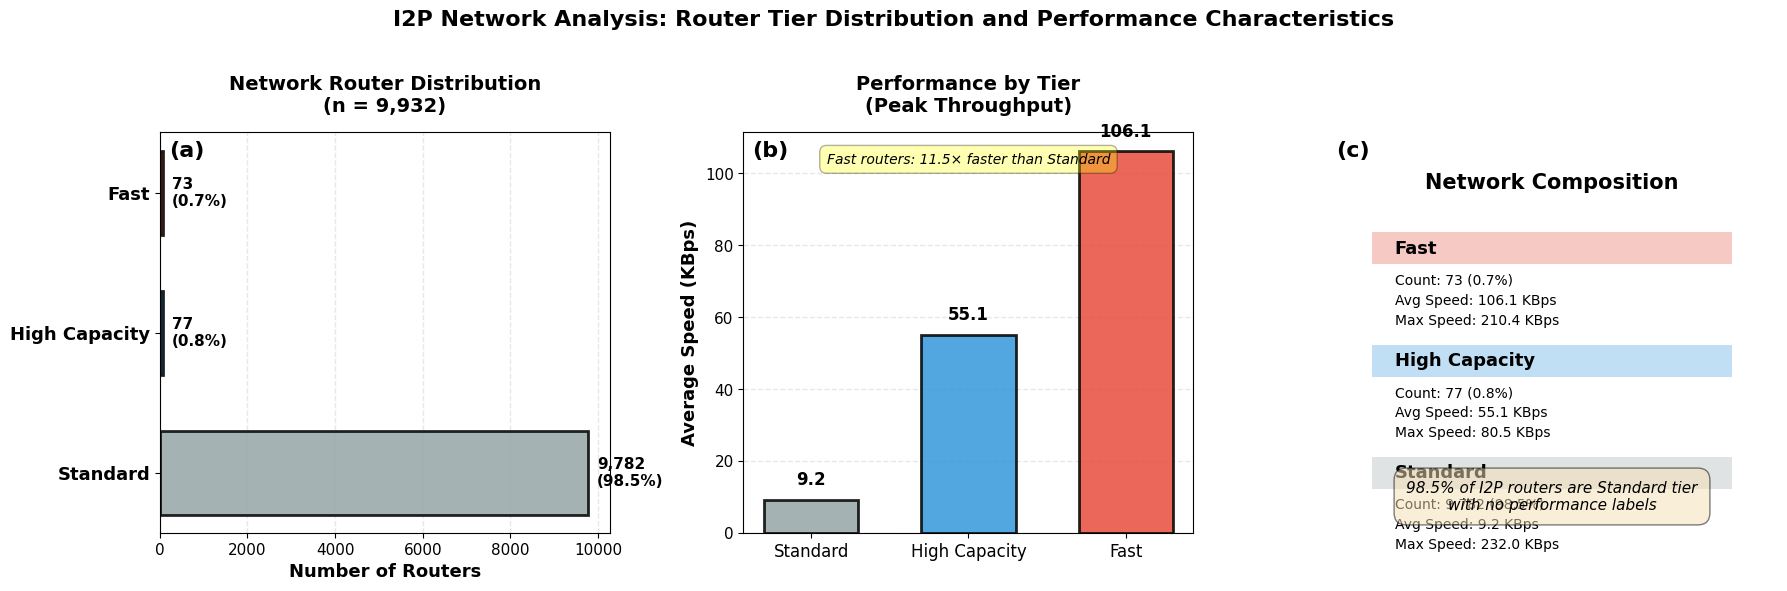

✅ Single comprehensive visualization complete


In [7]:
# Cell 5: Single Comprehensive Visualization
# Purpose: Publication-ready 3-panel figure for Experiment 5

import matplotlib.pyplot as plt
import numpy as np

print("Creating comprehensive publication figure...")

plt.rcParams['font.size'] = 11
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.patch.set_facecolor('white')

COLORS = {'Fast': '#e74c3c', 'High Capacity': '#3498db', 'Standard': '#95a5a6'}

# ================================================================
# PANEL 1: Router Tier Distribution
# ================================================================
ax1 = axes[0]

group_counts = profiles_complete['Group'].value_counts()
tiers = ['Standard', 'High Capacity', 'Fast']
counts = [group_counts.get(t, 0) for t in tiers]
colors = [COLORS[t] for t in tiers]

bars = ax1.barh(range(3), counts, color=colors, alpha=0.85,
                edgecolor='black', linewidth=2, height=0.6)

ax1.set_yticks(range(3))
ax1.set_yticklabels(tiers, fontsize=13, fontweight='bold')
ax1.set_xlabel('Number of Routers', fontsize=13, fontweight='bold')
ax1.set_title('Network Router Distribution\n(n = 9,932)',
              fontsize=14, fontweight='bold', pad=15)
ax1.grid(axis='x', alpha=0.3, linestyle='--', linewidth=1)
ax1.set_axisbelow(True)

# Add detailed labels
for i, (v, tier) in enumerate(zip(counts, tiers)):
    pct = (v / sum(counts)) * 100
    ax1.text(v + 200, i, f'{v:,}\n({pct:.1f}%)',
             va='center', ha='left', fontsize=11, fontweight='bold')

# ================================================================
# PANEL 2: Average Speed by Tier
# ================================================================
ax2 = axes[1]

avg_speeds = []
for tier in tiers:
    tier_df = profiles_complete[profiles_complete['Group'] == tier]
    avg_speed = tier_df['Speed'].mean()
    avg_speeds.append(avg_speed)

bars = ax2.bar(range(3), avg_speeds, color=colors, alpha=0.85,
               edgecolor='black', linewidth=2, width=0.6)

ax2.set_xticks(range(3))
ax2.set_xticklabels(tiers, fontsize=12, rotation=0)
ax2.set_ylabel('Average Speed (KBps)', fontsize=13, fontweight='bold')
ax2.set_title('Performance by Tier\n(Peak Throughput)',
              fontsize=14, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)
ax2.set_axisbelow(True)

# Add speed labels
for i, (v, tier) in enumerate(zip(avg_speeds, tiers)):
    ax2.text(i, v + 3, f'{v:.1f}', ha='center', va='bottom',
             fontsize=12, fontweight='bold')

# Add performance note
ax2.text(0.5, 0.95, 'Fast routers: 11.5× faster than Standard',
         transform=ax2.transAxes, ha='center', va='top',
         fontsize=10, style='italic',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))

# ================================================================
# PANEL 3: Tier Composition Summary
# ================================================================
ax3 = axes[2]
ax3.axis('off')

# Create summary statistics
summary_stats = []

for tier in ['Fast', 'High Capacity', 'Standard']:
    tier_df = profiles_complete[profiles_complete['Group'] == tier]
    count = len(tier_df)
    pct = (count / len(profiles_complete)) * 100
    avg_speed = tier_df['Speed'].mean()
    max_speed = tier_df['Speed'].max()

    summary_stats.append({
        'Tier': tier,
        'Count': count,
        'Percent': pct,
        'Avg_Speed': avg_speed,
        'Max_Speed': max_speed
    })

# Create text display
y_position = 0.9
ax3.text(0.5, y_position, 'Network Composition',
         ha='center', va='top', fontsize=15, fontweight='bold',
         transform=ax3.transAxes)

y_position -= 0.15

for stat in summary_stats:
    tier = stat['Tier']
    color = COLORS[tier]

    # Tier header
    ax3.add_patch(plt.Rectangle((0.1, y_position - 0.08), 0.8, 0.08,
                                facecolor=color, alpha=0.3,
                                transform=ax3.transAxes))

    ax3.text(0.15, y_position - 0.04, f"{tier}",
             ha='left', va='center', fontsize=13, fontweight='bold',
             transform=ax3.transAxes)

    # Statistics
    ax3.text(0.15, y_position - 0.12,
             f"Count: {stat['Count']:,} ({stat['Percent']:.1f}%)",
             ha='left', va='center', fontsize=10,
             transform=ax3.transAxes)

    ax3.text(0.15, y_position - 0.17,
             f"Avg Speed: {stat['Avg_Speed']:.1f} KBps",
             ha='left', va='center', fontsize=10,
             transform=ax3.transAxes)

    ax3.text(0.15, y_position - 0.22,
             f"Max Speed: {stat['Max_Speed']:.1f} KBps",
             ha='left', va='center', fontsize=10,
             transform=ax3.transAxes)

    y_position -= 0.28

# Add key finding
ax3.text(0.5, 0.05,
         '98.5% of I2P routers are Standard tier\nwith no performance labels',
         ha='center', va='bottom', fontsize=11, style='italic',
         transform=ax3.transAxes,
         bbox=dict(boxstyle='round,pad=0.8', facecolor='wheat', alpha=0.5))

# Panel labels
for i, ax in enumerate(axes):
    ax.text(0.02, 0.98, f'({chr(97+i)})', transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top')

# Main title
fig.suptitle('I2P Network Analysis: Router Tier Distribution and Performance Characteristics',
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('experiment5_final.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Saved: experiment5_final.png")
plt.show()

print("="*70)
print("✅ Single comprehensive visualization complete")
print("="*70)